# Difference between subject performance in using programming languages. 
## (A trial exam problem for Probabilistic Programming)

This exam exercise is based on: [Regina Hebig, Christoph Seidl, Thorsten Berger, John Kook Pedersen, Andrzej Wasowski: Model transformation languages under a magnifying glass: a controlled experiment with Xtend, ATL, and QVT. ESEC/SIGSOFT FSE 2018: 445-455](./2018-fse-model-trafos-regina-thorsten-christoph.pdf).  We summarize all the information needed in the exercise text, but please consult the PDF of the paper, if you need more information (we will point to the right sections, to make it easier for you). 

This experiment compared three transformation langaguages (ATL, QVT-O, and Xtend).  Transformation languages are languages for implementing syntax transformations (used for transforming data, models, or programs). The **treatment** in our experiment is the *transformation language* (a, q, or x for short).  We asked 3 random groups of students to solve 3 tasks in one of the languages. The first task, **Comprehend**, required understanding a transformation program.  The second task, **Change**, required changing a transformation program to accommodate a new requirement.  The third task, **Create**, required creating a transformation program.   Clearly, the three tasks cannot be solved on the same program.  Once a program has been understood (Comprehend) and changed (Change), creating it would become an exercise in memorizing, not in programming.  So for the third task we change the subject program.  We use two subject programs, one called *FM*, involving some manipulation of Feature Models, and one called *RE*, involving some manipulation of the Relational Model.  The content of the programs is not important for the task.

Each data point collected in the experiment is thus then characterized by: task, language, and outcome. The task ranges over: ComprehendFM, ComprehendRE, ChangeFM, ChangeRE, CreateFM, and CreateRE (thus two pieces of information, the task and the model are combined in this single column).  The language ranges over a, q, and x. The outcome is a value between 0 and 1 (percentage of points obtained after grading the subject solution by experts for correctness).  We do not know which rows originate from the same subjects (like in the baseball example), but the experiment design largely accounts for this before analysis -- the so called between-subjects design with cross-over (See section 4.1 in the paper if you are interested).  The data is distributed in the file [./model-transformation-languages.csv](./model-transformation-languages.csv) together with this exam problem.

The paper formulates hypothesis in Section 4.3:

**H1** Subjects comprehending a QVT-O or Xtend transformation perform better than those who comprehend a transformation in ATL.

**H1_0** : Subjects comprehending a QVT-O or Xtend transformation perform worse or equal to those comprehending an ATL transformation.

**H2**: Subjects who change a transformation written in QVT-O or Xtend perform better than those who change a transformation in ATL.

**H2_0**: Subjects changeing a transformation written in QVT-O or Xtend perform worse or equal to those who change an ATL transformation.

**H3**: Subjects who create a model transformation in QVT-O or Xtend perform better than those who create a transformation in ATL.

**H3_0**: Subjects who create a model transformation in QVT-O or Xtend perform worse or equal to those who create a transformation in ATL.

**H4**: Subjects who comprehend a transformation in QVT-O perform better than those comprehending a transformation in Xtend.

**H4_0** : Subjects who comprehend a transformation written in QVT-O perform worse or equal to those comprehending it in Xtend.

**H5**: Subjects changing a transformation written in QVT-O perform better than the subjects who change an Xtend transformation.

**H5_0**: Subjects changing a transformation in QVT-O perform worse or equal than the subjects who change an Xtend transformation.

**H6**: Subjects who create a model transformation in QVT-O perform better than those who create a transformation in Xtend.

**H6_0**: Subjects who create a model transformation in QVT-O perform worse or equal to those who create a transformation in Xtend.

The paper uses standard frequentist statistics to analyze these data and it reports, pretty much a negative, result that there is no added benefit of using a more specialized language, like ATL, over the other two (that represent more standard languages).  

Your task is to uses Bayesian Inference and Bayesion Decision making to decide wether these hypothesis holds, or possibly reject them. This includes:

* Loading and cleaning the data (some entries have empty values for the performance/outcome column.  This means that a result is not available, and the row should be ignored)

* Design tests for hypotheses in pyMC3 comparing the languages.

* Make sure that you explain your model idea in English (and possibly using a figure) before showing the python code.

* Make sure that you check the quality of the sampling process (and comment whether the quality is good, and whether you had to make any corrections during the modeling).

The exam is to be handed in via LearnIT.  It is possible to work in 1-2 person groups. It is OK to use all written and online material, but not to discuss the exam problem with anybody, except with the team members, before the submission.  

You should handin a zip file with a jupyter notebook and the data file (so that we can run it), and a PDF rendering of the jupyter notebook.  The report should contain analysis of the model design, sampling quality, the decision outcome for each hypothesis and a conclusion.  After conclusion write a few sentences reflecting on the division of work if you prepared the solution in a group.

The hand-in is via learnIT.

In [1]:
import pandas as pd
import pymc3 as pm
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter('ignore', UserWarning) # avoid printing the annoying user warning, likely a bug
warnings.simplefilter('ignore', FutureWarning) 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



## Data Format
Empty performance field means that the result is not available. The data needs to be cleaned of these entries.
ca 39-41 entries is available for each task (a bit less after cleaning)

In [2]:
data = pd.read_csv ("model-transformation-languages.csv")
data.replace ('', np.nan, inplace=True)
data.dropna (subset=['outcome'], inplace=True)

ComprehendFM = data[data.task == 'ComprehendFM']
ComprehendRE = data[data.task == 'ComprehendRE']
ChangeFM = data[data.task == 'ChangeFM']
ChangeRE = data[data.task == 'ChangeRE']
CreateFM = data[data.task == 'CreateFM']
CreateRE = data[data.task == 'CreateRE']

Comprehend = pd.concat ([ComprehendFM, ComprehendRE])
Change = pd.concat ([ChangeFM, ChangeRE])
Create = pd.concat ([CreateFM, CreateRE])

ComprehendQ = Comprehend[Comprehend.language == 'q']
ComprehendX = Comprehend[Comprehend.language == 'x']
ComprehendA = Comprehend[Comprehend.language == 'a']

ChangeQ = Change[Change.language == 'q']
ChangeX = Change[Change.language == 'x']
ChangeA = Change[Change.language == 'a']

CreateQ = Create[Create.language == 'q']
CreateX = Create[Create.language == 'x']
CreateA = Create[Create.language == 'a']

ComprehendQA = Comprehend[(Comprehend.language == 'q') | (Comprehend.language == 'a')]
ChangeQA = Change[(Change.language == 'q') | (Change.language == 'a')]
CreateQA = Create[(Create.language == 'q') | (Create.language == 'a')]

## Hypotheses

**H1** Subjects comprehending a QVT-O or Xtend transformation perform better than those who comprehend a transformation in ATL.

**H1_0** : Subjects comprehending a QVT-O or Xtend transformation perform worse or equal to those comprehending an ATL transformation.

I assume that the performance for each language and for each subject model of the task might be different. But I also assume that expected mean performance should be the same for the language across models, while perhaps the outliers (nu, sigma for StudentT) might different between models. So I propose the structure of the model to be:

In [3]:
def widget (languages, task): # eg. 'q' and 'Comprehend'
    language = str(languages)
    dataRE = data[(data.task == f"{task}RE") & (data.language.isin(languages))]
    dataFM = data[(data.task == f"{task}FM") & (data.language.isin(languages))]    

    mu = pm.Normal(f"mu_{task}_{language}", mu=0.4, sigma=0.5)
    sigma = pm.Uniform(f"sigma_{task}_{language}", lower=0.05, upper=0.95)
    
    nuRE = pm.Exponential (f"nu_RE_{task}_{language}", lam=1.0/29.0)
    muRE = pm.Normal (f"mu_RE_{task}_{language}", mu=mu, sigma=sigma)
    sigmaRE = pm.Uniform (f"sigma_RE_{task}_{language}", lower=0.05, upper=0.95)
    taskRE = pm.StudentT(f"RE_{task}_{language}", nu=nuRE+1, mu=muRE, sigma=sigmaRE, observed=dataRE.outcome)

    nuFM = pm.Exponential(f"nu_FM_{task}_{language}", lam=1.0/29.0)
    muFM = pm.Normal(f"mu_FM_{task}_{language}", mu=mu, sigma=sigma)
    sigmaFM = pm.Uniform(f"sigma_FM_{task}_{language}", lower=0.05, upper=0.95)
    taskFM = pm.StudentT(f"FM_{task}_{language}", nu=nuFM+1, mu=muFM, sigma=sigmaFM, observed=dataFM.outcome)
    
    return mu, sigma

In [4]:
def analyze (languages1, languages2, task, details=False):
    with pm.Model() as model_h1:
        mu1, sigma1 = widget (languages1, task)
        mu2, sigma2 = widget (languages2, task)
        diff = pm.Deterministic(f"diff_{str(task)}_{str(languages1)}_{str(languages2)}", mu2-mu1)
        
        pm.model_to_graphviz (model_h1)    
        trace = pm.sample(300,cores=3,tune=300,target_accept=0.95)
    
    if (details):
        pm.traceplot (trace)
        az.summary (trace)
        
    fig, ax = plt.subplots(3,2, figsize=(10,7))

    # posterior difference
    pm.plot_posterior(
        trace[diff.name], ax=ax[0,0], point_estimate='mode', 
        credible_interval=0.95, kind='hist', ref_val=0.0, rope=(-0.1,+0.1)
    )
    ax[0,0].set_xlabel(diff.name, fontdict={'fontsize':13})
    
    # scatter plot
    ax[0,1].scatter (trace[mu1.name], trace[mu2.name])
    ax[0,1].set_xlabel(f"{mu1.name} vs {mu2.name}", fontdict={'fontsize':13})
    
    # first mean posterior
    pm.plot_posterior(
        trace[mu1.name], ax=ax[1,0], point_estimate='mode', 
        credible_interval=0.95, kind='hist'
    )
    ax[1,0].set_xlabel(mu1.name, fontdict={'fontsize':13})
    
    # second mean posterior
    pm.plot_posterior(
        trace[mu2.name], ax=ax[1,1], point_estimate='mode', 
        credible_interval=0.95, kind='hist'
    )
    ax[1,1].set_xlabel(mu2.name, fontdict={'fontsize':13})
    
    # dataset1 + dataset2
    data1 = data[(data.task == f"{task}RE") & (data.language.isin(languages1))]
    data2 = data[(data.task == f"{task}FM") & (data.language.isin(languages2))]  
    ax[2,0].hist(data1.outcome, bins = 10)
    ax[2,1].hist(data2.outcome, bins = 10)
    
    plt.tight_layout()
    
    return trace

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma_FM_Comprehend_['a'], mu_FM_Comprehend_['a'], nu_FM_Comprehend_['a'], sigma_RE_Comprehend_['a'], mu_RE_Comprehend_['a'], nu_RE_Comprehend_['a'], sigma_Comprehend_['a'], mu_Comprehend_['a'], sigma_FM_Comprehend_['x', 'q'], mu_FM_Comprehend_['x', 'q'], nu_FM_Comprehend_['x', 'q'], sigma_RE_Comprehend_['x', 'q'], mu_RE_Comprehend_['x', 'q'], nu_RE_Comprehend_['x', 'q'], sigma_Comprehend_['x', 'q'], mu_Comprehend_['x', 'q']]
Sampling 3 chains, 0 divergences: 100%|██████████| 1800/1800 [00:03<00:00, 543.00draws/s]


<MultiTrace: 3 chains, 300 iterations, 27 variables>

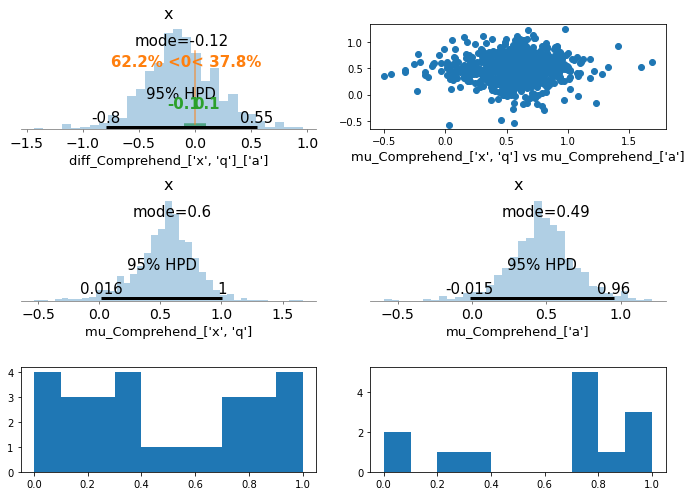

In [5]:
analyze (['x','q'], ['a'], 'Comprehend')

We cannot accept H1_0 that QVT-O or Xtend transformation perform worse or equal to those comprehending an ATL transformation. The difference of 0 is within HDI, and fairly likely (close to mode). We cannot accept the hypothesis H1 either (that Subjects comprehending a QVT-O or Xtend transformation perform better than those who comprehend a transformation in ATL.) because the HDI is very wide, wider than ROPE.

**H2**: Subjects who change a transformation written in QVT-O or Xtend perform better than those who change a transformation in ATL.

**H2_0**: Subjects changeing a transformation written in QVT-O or Xtend perform worse or equal to those who change an ATL transformation.

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma_FM_Change_['a'], mu_FM_Change_['a'], nu_FM_Change_['a'], sigma_RE_Change_['a'], mu_RE_Change_['a'], nu_RE_Change_['a'], sigma_Change_['a'], mu_Change_['a'], sigma_FM_Change_['x', 'q'], mu_FM_Change_['x', 'q'], nu_FM_Change_['x', 'q'], sigma_RE_Change_['x', 'q'], mu_RE_Change_['x', 'q'], nu_RE_Change_['x', 'q'], sigma_Change_['x', 'q'], mu_Change_['x', 'q']]
Sampling 3 chains, 0 divergences: 100%|██████████| 1800/1800 [00:06<00:00, 291.23draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


<MultiTrace: 3 chains, 300 iterations, 27 variables>

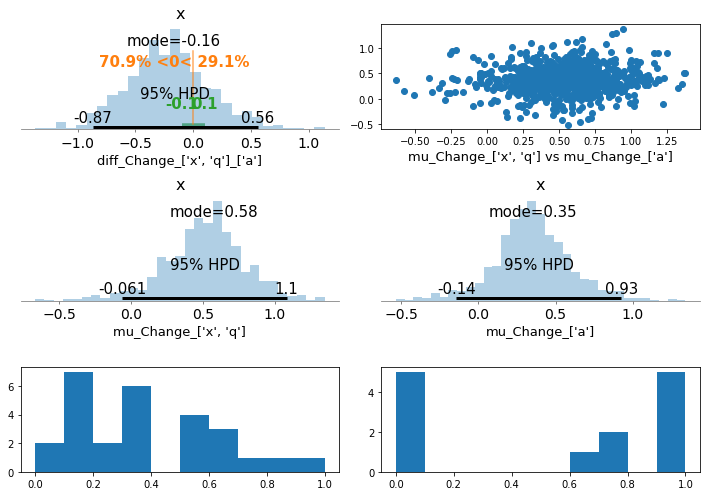

In [6]:
analyze (['x','q'], ['a'], 'Change')

The reesults regarding hypothesis H2 are inconclusive.

**H3**: Subjects who create a model transformation in QVT-O or Xtend perform better than those who create a transformation in ATL.

**H3_0**: Subjects who create a model transformation in QVT-O or Xtend perform worse or equal to those who create a transformation in ATL.

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma_FM_Create_['a'], mu_FM_Create_['a'], nu_FM_Create_['a'], sigma_RE_Create_['a'], mu_RE_Create_['a'], nu_RE_Create_['a'], sigma_Create_['a'], mu_Create_['a'], sigma_FM_Create_['x', 'q'], mu_FM_Create_['x', 'q'], nu_FM_Create_['x', 'q'], sigma_RE_Create_['x', 'q'], mu_RE_Create_['x', 'q'], nu_RE_Create_['x', 'q'], sigma_Create_['x', 'q'], mu_Create_['x', 'q']]
Sampling 3 chains, 0 divergences: 100%|██████████| 1800/1800 [00:04<00:00, 449.34draws/s]


<MultiTrace: 3 chains, 300 iterations, 27 variables>

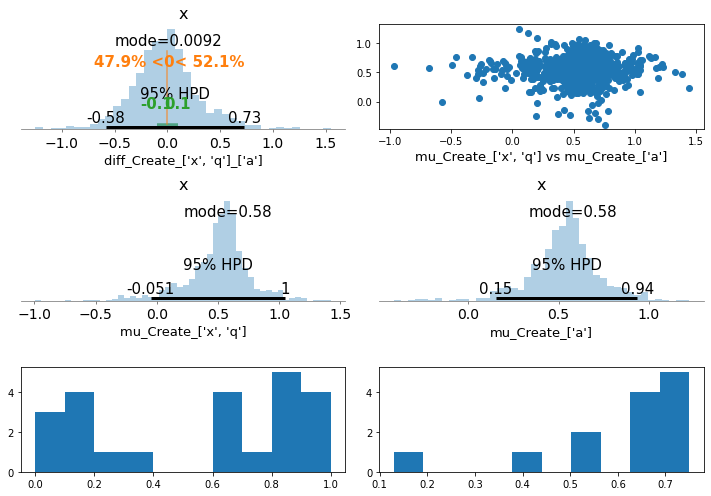

In [7]:
analyze (['x','q'], ['a'], 'Create')

As the main purpose of domain specific languages it is to make task
solving in a domain easier or more efficient. Thus, we formulate
the following hypotheses including null hypotheses:

H4: Subjects who comprehend a transformation in QVT-O perform
better than those comprehending a transformation in Xtend.

H4 0 : Subjects who comprehend a transformation written in QVT-O
perform worse or equal to those comprehending it in Xtend.

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma_FM_Comprehend_['x'], mu_FM_Comprehend_['x'], nu_FM_Comprehend_['x'], sigma_RE_Comprehend_['x'], mu_RE_Comprehend_['x'], nu_RE_Comprehend_['x'], sigma_Comprehend_['x'], mu_Comprehend_['x'], sigma_FM_Comprehend_['q'], mu_FM_Comprehend_['q'], nu_FM_Comprehend_['q'], sigma_RE_Comprehend_['q'], mu_RE_Comprehend_['q'], nu_RE_Comprehend_['q'], sigma_Comprehend_['q'], mu_Comprehend_['q']]
Sampling 3 chains, 0 divergences: 100%|██████████| 1800/1800 [00:03<00:00, 522.98draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


<MultiTrace: 3 chains, 300 iterations, 27 variables>

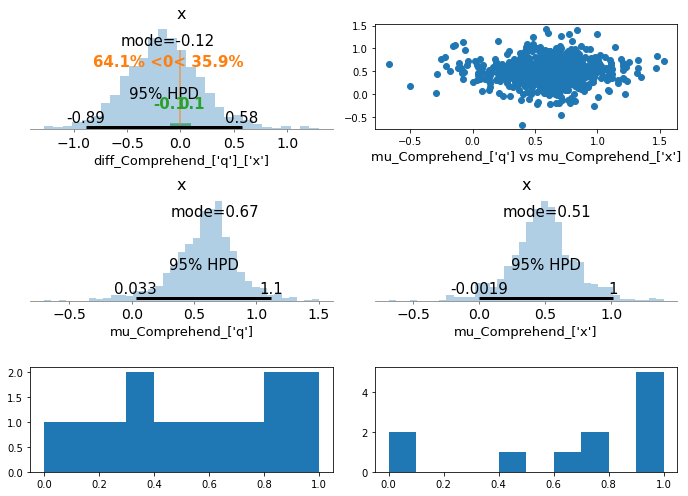

In [8]:
analyze (['q'], ['x'], 'Comprehend')

H5: Subjects changing a transformation written in QVT-O perform
better than the subjects who change an Xtend transformation.

H5 0 : Subjects changing a transformation in QVT-O perform worse
or equal than the subjects who change an Xtend transformation.

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma_FM_Change_['x'], mu_FM_Change_['x'], nu_FM_Change_['x'], sigma_RE_Change_['x'], mu_RE_Change_['x'], nu_RE_Change_['x'], sigma_Change_['x'], mu_Change_['x'], sigma_FM_Change_['q'], mu_FM_Change_['q'], nu_FM_Change_['q'], sigma_RE_Change_['q'], mu_RE_Change_['q'], nu_RE_Change_['q'], sigma_Change_['q'], mu_Change_['q']]
Sampling 3 chains, 0 divergences: 100%|██████████| 1800/1800 [00:05<00:00, 353.86draws/s]


<MultiTrace: 3 chains, 300 iterations, 27 variables>

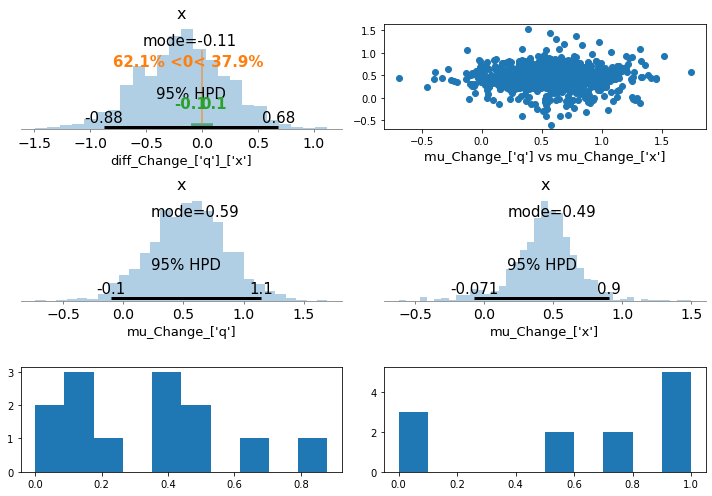

In [9]:
analyze (['q'], ['x'], 'Change')

H6: Subjects who create a model transformation in QVT-O perform
better than those who create a transformation in Xtend.

H6 0 : Subjects who create a model transformation in QVT-O perform
worse or equal to those who create a transformation in Xtend.

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma_FM_Create_['x'], mu_FM_Create_['x'], nu_FM_Create_['x'], sigma_RE_Create_['x'], mu_RE_Create_['x'], nu_RE_Create_['x'], sigma_Create_['x'], mu_Create_['x'], sigma_FM_Create_['q'], mu_FM_Create_['q'], nu_FM_Create_['q'], sigma_RE_Create_['q'], mu_RE_Create_['q'], nu_RE_Create_['q'], sigma_Create_['q'], mu_Create_['q']]
Sampling 3 chains, 0 divergences: 100%|██████████| 1800/1800 [00:03<00:00, 470.16draws/s]


<MultiTrace: 3 chains, 300 iterations, 27 variables>

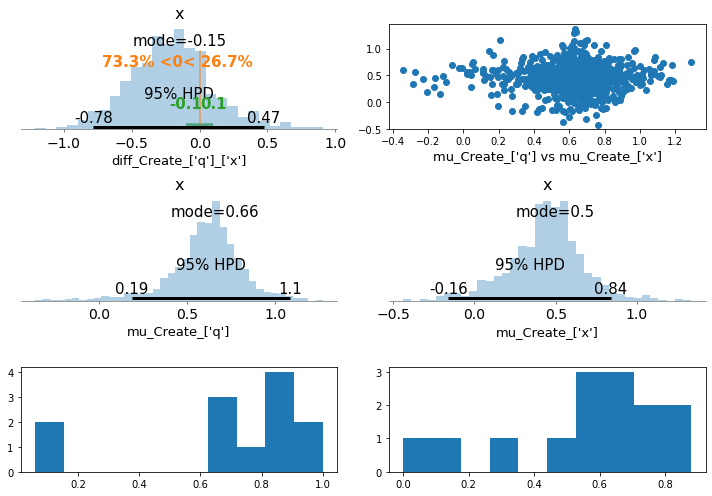

In [10]:
analyze (['q'], ['x'], 'Create')

# Data Plots

This section is devoted to plots of the data to understand whether groups are normally distributed (a kind of sanity plots). I imagine the following plots:

1. The plot of results for all tasks binned into 10 bins, or KDE (1x)
2. The plot of results for each task separately binned into 10 bins, or KDE (3x)
3. The plot of results for each language separately binned into 10 bins, or KDE (3x)
4. The plot of results for each language-task pair binned into 10 bins, or KDE (9x)
5. The plot of results of ATL + QVT combined for each task binned into 10 bins, or KDE. (3x)
6. Results per task model pairs (6 plots)

19 plots in total. Like in the paper we can see that the data is not really normal. We often have two bumps. Given the small sample sets this is not very comforting - the prior should be selected with rather large standard deviation.

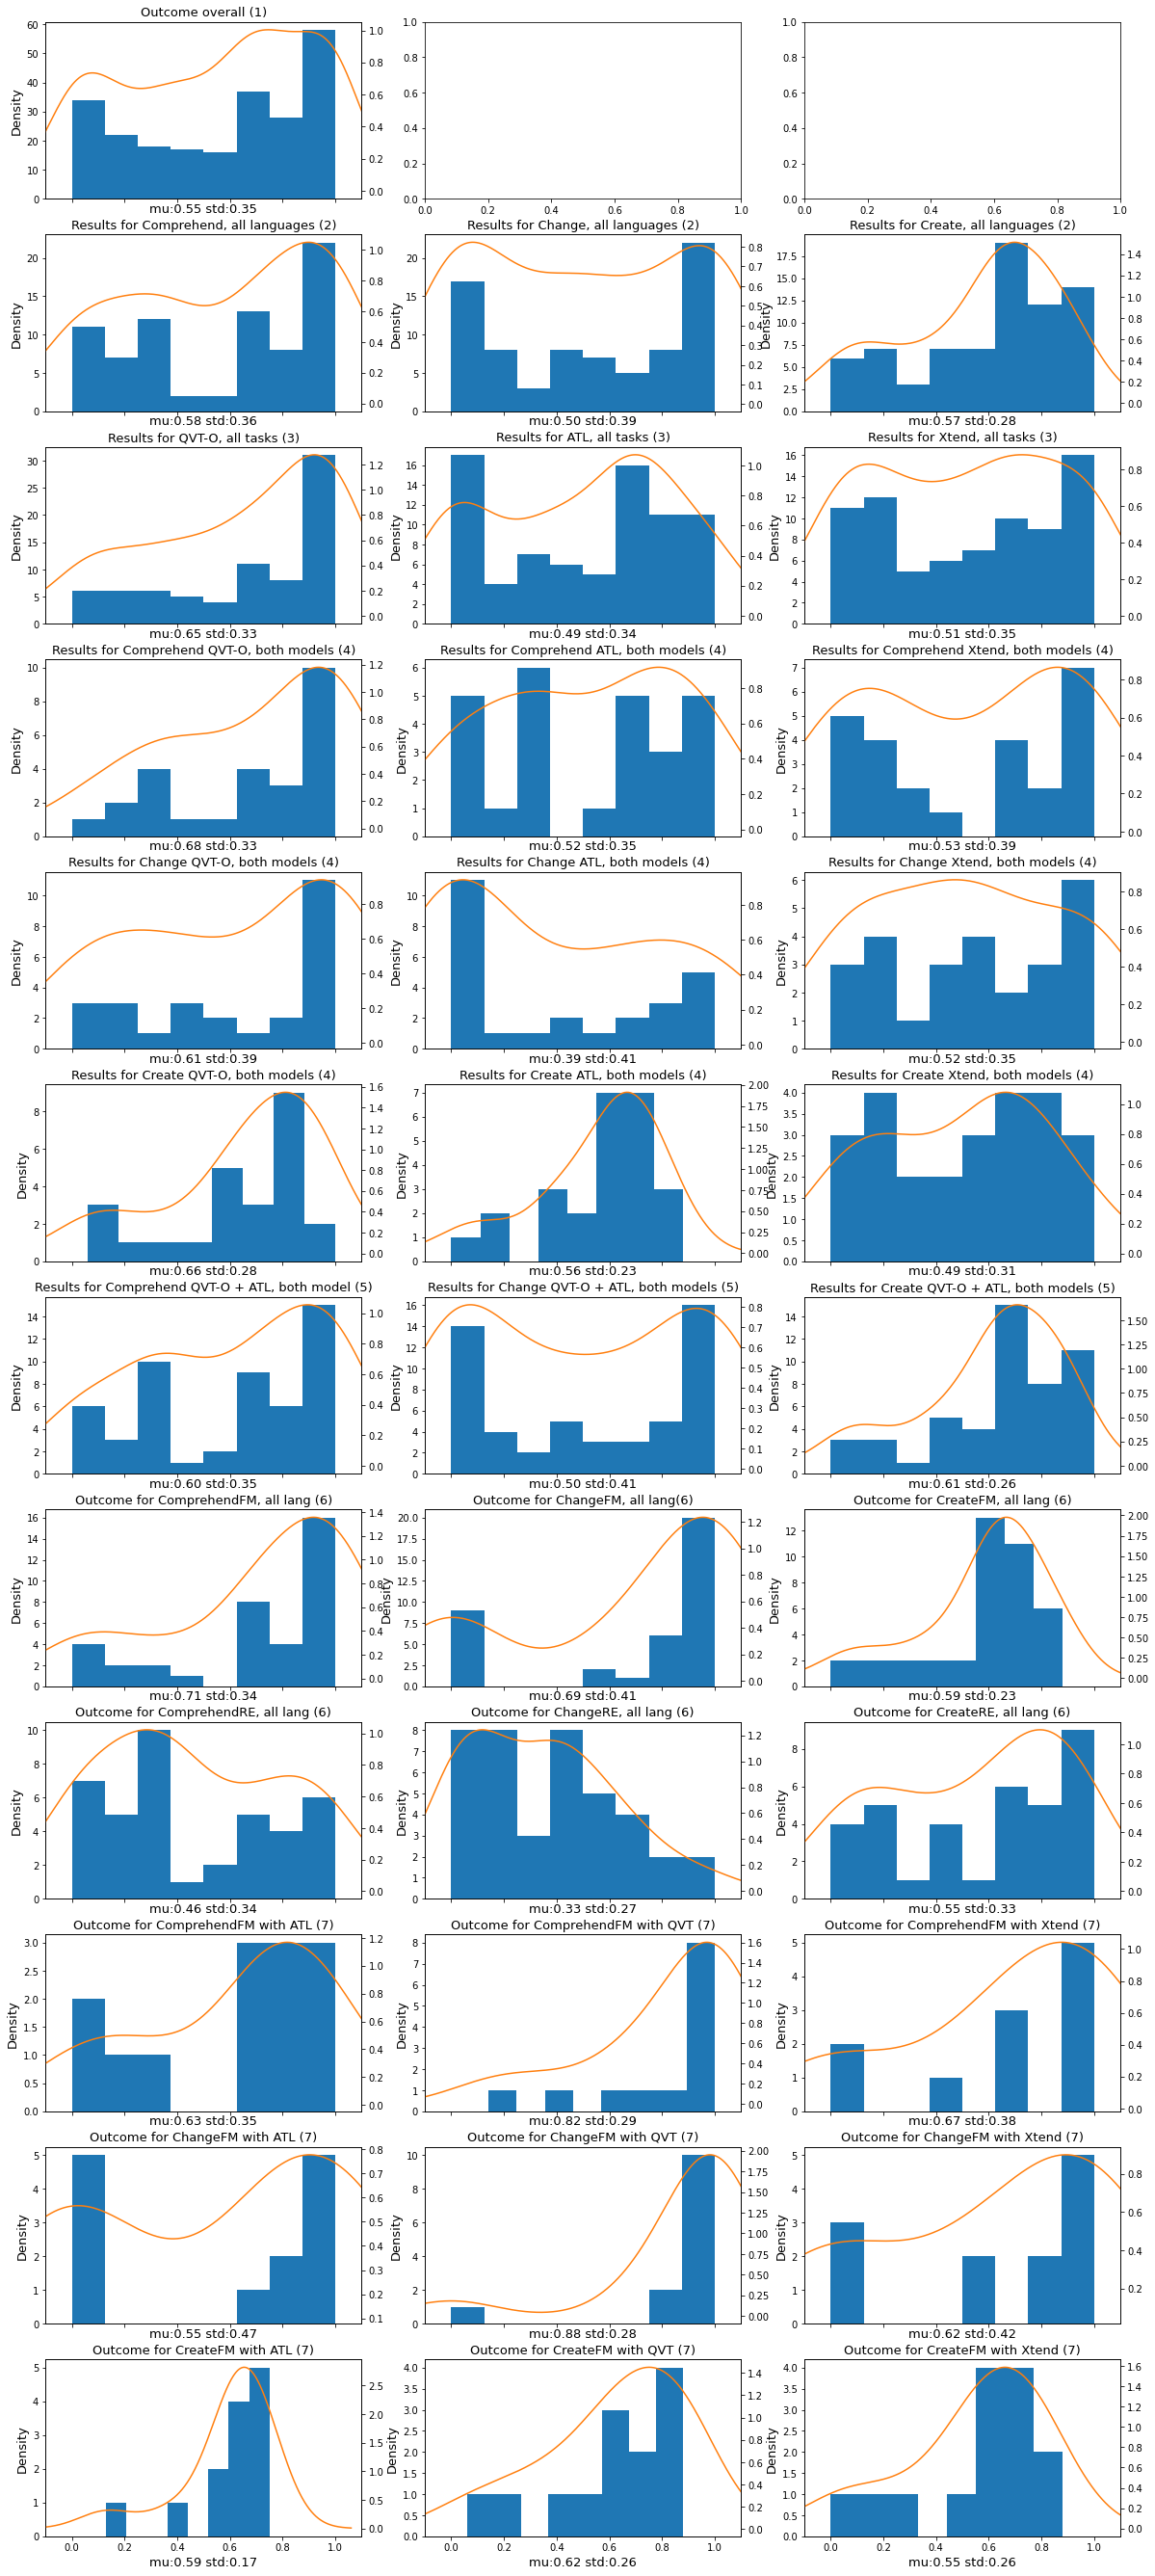

In [11]:
def plot_outcome (ax, data, label):
    data.outcome.plot.hist(ax=ax, bins = 8, sharex=False)
    mean = data.outcome.mean()
    std = data.outcome.std()
    ax.set_title(label, fontdict={'fontsize':13})    
    ax.set_ylabel("", fontdict={'fontsize':13})
    ax.set_xlabel(f"mu:{mean:.2f} std:{std:.2f}", fontdict={'fontsize':13})
    data.outcome.plot.kde(ax=ax, xlim=[-.1,1.1], secondary_y=True, sharex=False)
    
fig, ax = plt.subplots(12,3, figsize=(20,48))

# (1)
# fig.suptitle ("1. Outcome overall (all languages, all tasks)")
plot_outcome (ax[0,0], data, "Outcome overall (1)")

# (2)
plot_outcome (ax[1,0], Comprehend, "Results for Comprehend, all languages (2)")
plot_outcome (ax[1,1], Change, "Results for Change, all languages (2)")
plot_outcome (ax[1,2], Create, "Results for Create, all languages (2)")

# (3)
plot_outcome (ax[2,0], data[data.language =='q'], "Results for QVT-O, all tasks (3)")
plot_outcome (ax[2,1], data[data.language =='a'], "Results for ATL, all tasks (3)")
plot_outcome (ax[2,2], data[data.language =='x'], "Results for Xtend, all tasks (3)")

# (4)
plot_outcome (ax[3,0], ComprehendQ, "Results for Comprehend QVT-O, both models (4)")
plot_outcome (ax[3,1], ComprehendA, "Results for Comprehend ATL, both models (4)")
plot_outcome (ax[3,2], ComprehendX, "Results for Comprehend Xtend, both models (4)")
plot_outcome (ax[4,0], ChangeQ, "Results for Change QVT-O, both models (4)")
plot_outcome (ax[4,1], ChangeA, "Results for Change ATL, both models (4)")
plot_outcome (ax[4,2], ChangeX, "Results for Change Xtend, both models (4)")
plot_outcome (ax[5,0], CreateQ, "Results for Create QVT-O, both models (4)")
plot_outcome (ax[5,1], CreateA, "Results for Create ATL, both models (4)")
plot_outcome (ax[5,2], CreateX, "Results for Create Xtend, both models (4)")

# (5)
plot_outcome (ax[6,0], ComprehendQA, "Results for Comprehend QVT-O + ATL, both model (5)")
plot_outcome (ax[6,1], ChangeQA, "Results for Change QVT-O + ATL, both models (5)")
plot_outcome (ax[6,2], CreateQA, "Results for Create QVT-O + ATL, both models (5)")

# (6)
plot_outcome (ax[7,0], ComprehendFM, "Outcome for ComprehendFM, all lang (6)")
plot_outcome (ax[7,1], ChangeFM, "Outcome for ChangeFM, all lang(6)")
plot_outcome (ax[7,2], CreateFM, "Outcome for CreateFM, all lang (6)")
plot_outcome (ax[8,0], ComprehendRE, "Outcome for ComprehendRE, all lang (6)")
plot_outcome (ax[8,1], ChangeRE, "Outcome for ChangeRE, all lang (6)")
plot_outcome (ax[8,2], CreateRE, "Outcome for CreateRE, all lang (6)")

# (7) Sanity checks against Table 4 in the paper
plot_outcome (ax[9,0], ComprehendFM[ComprehendFM.language == 'a'], "Outcome for ComprehendFM with ATL (7)")
plot_outcome (ax[9,1], ComprehendFM[ComprehendFM.language == 'q'], "Outcome for ComprehendFM with QVT (7)")
plot_outcome (ax[9,2], ComprehendFM[ComprehendFM.language == 'x'], "Outcome for ComprehendFM with Xtend (7)")
plot_outcome (ax[10,0], ChangeFM[ChangeFM.language == 'a'], "Outcome for ChangeFM with ATL (7)")
plot_outcome (ax[10,1], ChangeFM[ChangeFM.language == 'q'], "Outcome for ChangeFM with QVT (7)")
plot_outcome (ax[10,2], ChangeFM[ChangeFM.language == 'x'], "Outcome for ChangeFM with Xtend (7)")
plot_outcome (ax[11,0], CreateFM[CreateFM.language == 'a'], "Outcome for CreateFM with ATL (7)")
plot_outcome (ax[11,1], CreateFM[CreateFM.language == 'q'], "Outcome for CreateFM with QVT (7)")
plot_outcome (ax[11,2], CreateFM[CreateFM.language == 'x'], "Outcome for CreateFM with Xtend (7)")

# A really annoying correction of some label problem that I could not figure out.
for i in range(11):
    for j in range(3):
        #if (ax[i,j]!= None): 
        ax[i,j].xaxis.label.set_visible(True)

#plt.tight_layout()        
plt.show()

# A model with nominal predictor (multiple groups) based on Ch. 19

Let $S$ be the size of our dataset.  We will create $S$ nodes of normal type (as in Figure 19.2) controlled by the Normal likelihood, with a mean determined by a linear combination of class parameters $\beta$.

We have three groups (a, q, x), one for each language.  We map them to integer numbers so that we can use them for indexing.  Thus our parameter $\beta$ will be an array.

In [12]:
S = len(data)
n_groups = 3 

Now we establish a mapping of each data entry into the nominal group identifier.  We will use it later to create a regresion expression that will predict the value of mean outcome based on the used language.

In [13]:
x_grp = data.language.map (lambda l: 0 if l == 'a' else 1 if l == 'q' else 2)

The model is probably the easiest to read from the bottom, consulting Fig. 19.2 in Kruschke. The outcome node (in the last line) is vectorized. It represents $S$ observation, all govern by the same mean and standard deviation.  The standard deviation $\sigma_\mathrm{y}$ is broad and uninformed.  The mean $\mu_\mathrm{y}$ is defined by a linear combination of an intercept parameter $\beta_0$ and the weight parameters $\beta_i$ where $i=0, 1, 3$.

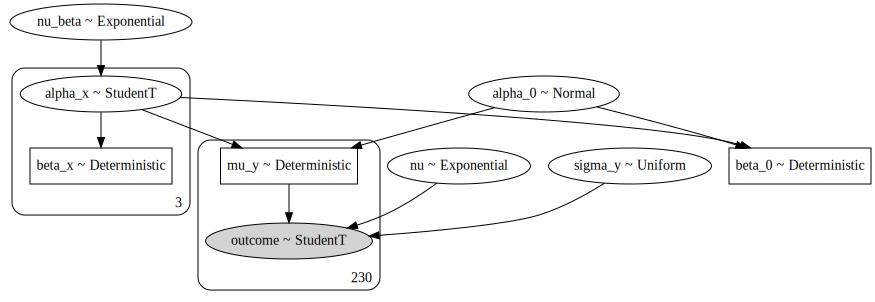

In [14]:
with pm.Model() as model_nominal_gaussian:
    sigma_beta = 1 # Actually the book writes that setting it to a large constant results in estimates most analogous to traditional ANOVA (a standard deviation 1 is actually large in our context.)
    S0 = 1
    M0 = 0.5
   
    alpha_0 = pm.Normal ("alpha_0", mu=M0, sigma=S0)
    nu_beta = pm.Exponential("nu_beta", lam=1.0/19.0)
    alpha_x = pm.StudentT ("alpha_x", mu=0, sigma=sigma_beta, nu=nu_beta+1, shape=n_groups)
        
    alpha_bar = (alpha_x[0] + alpha_x[1] + alpha_x[2]) / 3.0
    
    beta_0 = pm.Deterministic ("beta_0", alpha_0 + alpha_bar)
    beta_x = pm.Deterministic ("beta_x", alpha_x - alpha_bar)
    
    mu_y = pm.Deterministic ("mu_y", alpha_0 + alpha_x[x_grp])
    sigma_y = pm.Uniform ("sigma_y", lower=0.01, upper=1.00)
    
    nu = pm.Exponential("nu", lam=1.0/19.0) # we take nu to be about 20, becuase we know that the Data is not normally distributed
    outcome = pm.StudentT ("outcome", nu=nu+1, mu=mu_y, sigma=sigma_y, observed=data.outcome, shape=S)

pm.model_to_graphviz (model_nominal_gaussian) 

In [15]:
with model_nominal_gaussian:
    trace = pm.sample(5000,cores=3,tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [nu, sigma_y, alpha_x, nu_beta, alpha_0]
Sampling 3 chains, 0 divergences: 100%|██████████| 27000/27000 [01:36<00:00, 278.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


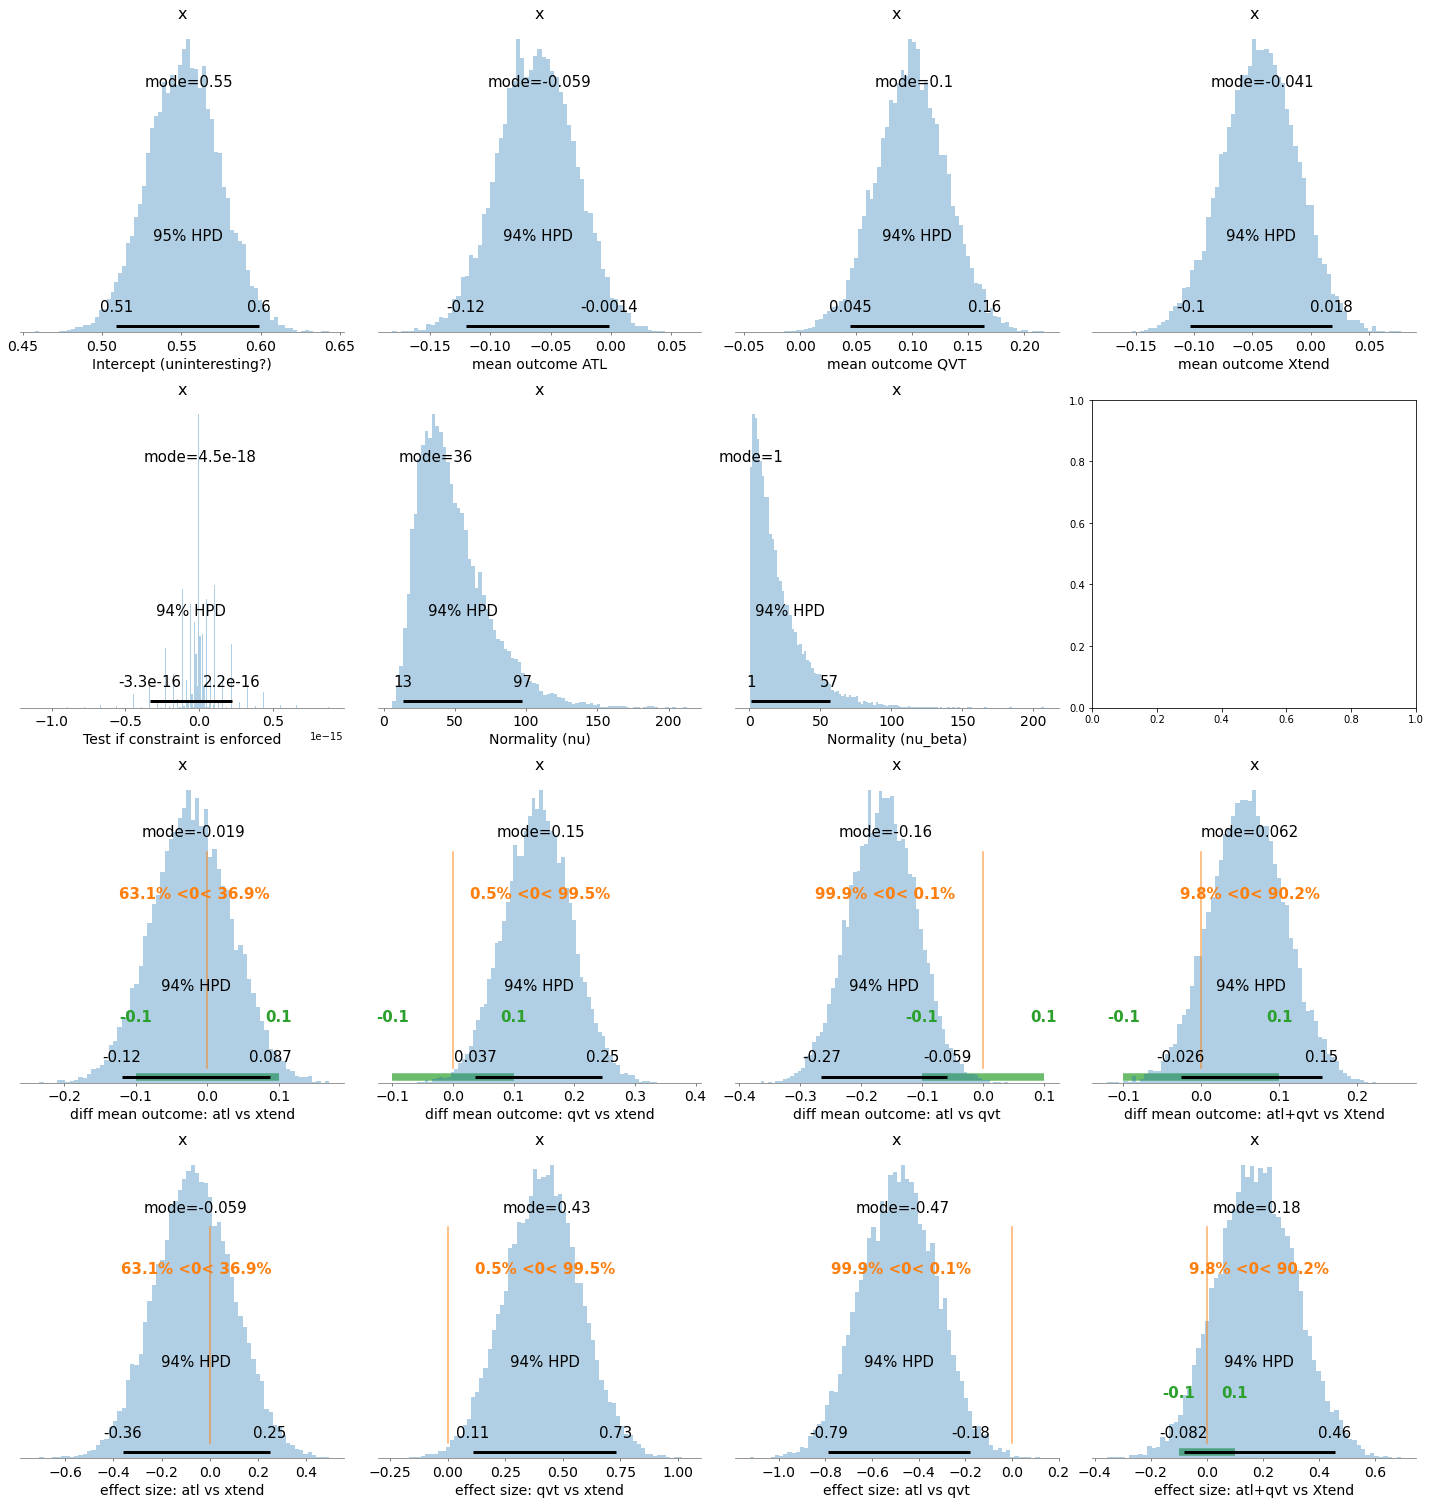

In [16]:
fig, ax = plt.subplots(4,4, figsize=(20,21))

with model_nominal_gaussian:
    pm.plot_posterior(
        trace["beta_0"], point_estimate='mode', ax=ax[0,0],
        credible_interval=0.95, kind='hist'
    )
    ax[0,0].set_xlabel("Intercept (uninteresting?)", fontdict={'fontsize':14})
    
    pm.plot_posterior(
        trace['beta_x'][:,0], point_estimate='mode', ax=ax[0,1],
        credible_interval=0.94, kind='hist'
    )
    ax[0,1].set_xlabel("mean outcome ATL", fontdict={'fontsize':14})
    pm.plot_posterior(
        trace['beta_x'][:,1], point_estimate='mode', ax=ax[0,2],
        credible_interval=0.94, kind='hist'
    )
    ax[0,2].set_xlabel("mean outcome QVT", fontdict={'fontsize':14})
    pm.plot_posterior(
        trace['beta_x'][:,2], point_estimate='mode', ax=ax[0,3],
        credible_interval=0.94, kind='hist'
    )
    ax[0,3].set_xlabel("mean outcome Xtend", fontdict={'fontsize':14})
    
    # A test if correction of betas worked (seems reasonable)
    beta_sum = trace['beta_x'][:,0] + trace['beta_x'][:,1] + trace['beta_x'][:,2]
    pm.plot_posterior(beta_sum, point_estimate='mode', ax=ax[1,0], kind='hist')
    ax[1,0].set_xlabel("Test if constraint is enforced", fontdict={'fontsize':14})
    
    #Normality
    pm.plot_posterior (trace['nu']+1, point_estimate='mode', ax=ax[1,1], kind='hist')
    ax[1,1].set_xlabel("Normality (nu)", fontdict={'fontsize':14})
    
    pm.plot_posterior (trace['nu_beta']+1, point_estimate='mode', ax=ax[1,2], kind='hist')
    ax[1,2].set_xlabel("Normality (nu_beta)", fontdict={'fontsize':14})
    
    # Contrasts
    pm.plot_posterior(
        trace["beta_x"][:,0] - trace["beta_x"][:,2], point_estimate='mode', ax=ax[2,0], ref_val=0,
        credible_interval=0.94, kind='hist', rope=(-0.1,+0.1)
    )
    ax[2,0].set_xlabel("diff mean outcome: atl vs xtend", fontdict={'fontsize':14})

    pm.plot_posterior(
        trace["beta_x"][:,1] - trace["beta_x"][:,2], point_estimate='mode', ax=ax[2,1], ref_val=0,
        credible_interval=0.94, kind='hist', rope=(-0.1,+0.1)
    )
    ax[2,1].set_xlabel("diff mean outcome: qvt vs xtend", fontdict={'fontsize':14})

    pm.plot_posterior(
        trace["beta_x"][:,0] - trace["beta_x"][:,1], point_estimate='mode', ax=ax[2,2], ref_val=0,
        credible_interval=0.94, kind='hist', rope=(-0.1,+0.1)
    )
    ax[2,2].set_xlabel("diff mean outcome: atl vs qvt", fontdict={'fontsize':14})

    pm.plot_posterior(
        0.5*trace["beta_x"][:,0] + 0.5*trace["beta_x"][:,1] - trace["beta_x"][:,2], point_estimate='mode', ax=ax[2,3], ref_val=0,
        credible_interval=0.94, kind='hist', rope=(-0.1,+0.1)
    )
    ax[2,3].set_xlabel("diff mean outcome: atl+qvt vs Xtend", fontdict={'fontsize':14})
    
    # Effect sizes
    pm.plot_posterior(
        (trace["beta_x"][:,0] - trace["beta_x"][:,2])/trace["sigma_y"], point_estimate='mode', ax=ax[3,0], ref_val=0,
        credible_interval=0.94, kind='hist'
    )
    ax[3,0].set_xlabel("effect size: atl vs xtend", fontdict={'fontsize':14})

    pm.plot_posterior(
        (trace["beta_x"][:,1] - trace["beta_x"][:,2])/trace["sigma_y"], point_estimate='mode', ax=ax[3,1], ref_val=0,
        credible_interval=0.94, kind='hist'
    )
    ax[3,1].set_xlabel("effect size: qvt vs xtend", fontdict={'fontsize':14})

    pm.plot_posterior(
        (trace["beta_x"][:,0] - trace["beta_x"][:,1])/trace["sigma_y"], point_estimate='mode', ax=ax[3,2], ref_val=0,
        credible_interval=0.94, kind='hist'
    )
    ax[3,2].set_xlabel("effect size: atl vs qvt", fontdict={'fontsize':14})

    pm.plot_posterior(
        (0.5*trace["beta_x"][:,0] + 0.5*trace["beta_x"][:,1] - trace["beta_x"][:,2])/trace["sigma_y"], point_estimate='mode', ax=ax[3,3], ref_val=0,
        credible_interval=0.94, kind='hist', rope=(-0.1,0.1)
    )
    ax[3,3].set_xlabel("effect size: atl+qvt vs Xtend", fontdict={'fontsize':14})
         
plt.tight_layout()

**TODO** I think the effect size above might be wrongly computed.

The first row of plots is probably not very interesting.  This is just a distribution of mean outcome weight for each languages (all centered around 0). The middle raw plots the sum of mean outcomes for the languages. This should be zero, and we see that it is with very high precision, so the model seems to work.  The third row plots the expected differences (contrasts) between outcomes in language pairs. We can almost accept the hypothesis that the differences are smaller than one grade stop!

Also the effect size HDPs (4th row) all include zero as a credible value, and the mode is close to zero. This is indicative of no effect or weak effect. Unfortunately, we cannot conclude that the effect is negligible because size of the HDPs is in general larger than 0.2. I do not know what effect size would be acceptable in education kind of research though.

The entire exercise does show though that with Bayesian analysis we would be able to do a better model, probably with just a slightly larger sample.  Also it shows that nominal ANOVA does a better job than separate contrasts. I do not know exactly why, but somehow the samples from the third language somehow inform the model as well (perhaps setting a better intercept?).  It would be interesting to try a chapter 20 style model (so that also task influence is separated). This might give an improvement.

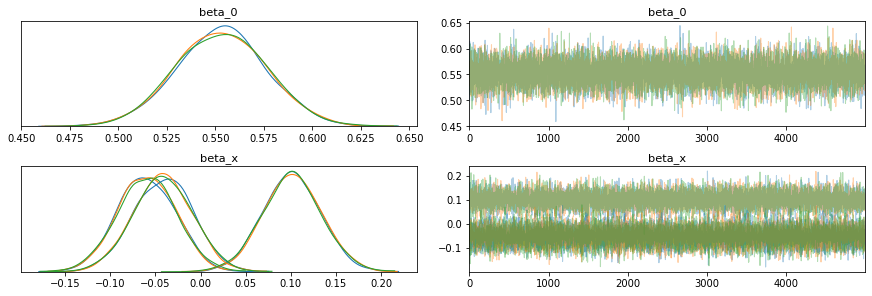

In [20]:
pm.traceplot(trace, var_names=['beta_0', 'beta_x'])
plt.show()

In [18]:
pm.summary (trace, var_names=['beta_0','beta_x'])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
beta_0     0.553  0.023   0.511    0.597        0.0      0.0   14937.0   
beta_x[0] -0.060  0.032  -0.120   -0.001        0.0      0.0   15242.0   
beta_x[1]  0.101  0.032   0.045    0.165        0.0      0.0   15524.0   
beta_x[2] -0.042  0.032  -0.103    0.018        0.0      0.0   15691.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
beta_0     14899.0   14932.0   11417.0    1.0  
beta_x[0]  12627.0   15274.0    9838.0    1.0  
beta_x[1]  14486.0   15516.0    9472.0    1.0  
beta_x[2]  11443.0   15688.0    9708.0    1.0

## Notes 

### A model with metric predictor (covariate) Section 19.4 in Kruschke

TODO

### A model with two groups of nominal predictors (Chapter 20): task-language regression

TODO

### Model Comparison

The t distribution in section 16.2 opens for a model comparison exercise.
This could be developed in later years.  Basically see whether the normal or studentt model is better for this case. 

### Power Analysis